In [8]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tf_keras.optimizers import Adam
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [9]:
def SMA(arr, n=10):
    """Compute the moving average of an array."""
    res = [sum(arr[i-n:i])/n for i in range(n, len(arr))]
    std = [np.std(arr[i-n:i]) for i in range(n, len(arr))]
    return res, std 

def sparse(arr, n=10, s=2):
    """Compute the sparse average of an array."""
    l = len(arr)
    res = []
    avg_ind = []
    for i in range(0, l-s*n, n):
        res.append(float(arr[i])) #Append float instead of np array, mostly for plotting
        avg_ind.append(float(i+n))
    
    return np.array(res, dtype=np.float64), np.array(avg_ind, dtype=np.float64)

In [22]:
start_date = '2021-01-01'
end_date = '2025-04-10'
index = 'AAPL'  # Example stock symbol, change as needed
# Get the stock data
stock = yf.download(index, start=start_date, end=end_date)

data = pd.DataFrame.to_numpy(stock['Close'])
data = data-data[0]
days = np.atleast_2d(np.arange(len(data), dtype=np.float64)).T

#find the moving average
day_avg = 15
SMA_data, std_data = SMA(data, n=day_avg)

# Downsample the data, s ensures there is unsampled data for prediction
sparse_data, sparse_days = sparse(SMA_data, n=day_avg, s=4)
sparse_data = tf.convert_to_tensor(sparse_data)
sparse_std, _ = tf.convert_to_tensor(sparse(std_data, n=day_avg, s=4))
observation_noise_variance_var = tf.convert_to_tensor(sparse_std**2)
sparse_days = tf.convert_to_tensor(np.atleast_2d(sparse_days).T)

[*********************100%***********************]  1 of 1 completed
/var/folders/hq/gsdbcm4x4w90mhd9khtb6yzh0000gn/T/ipykernel_77565/2656596897.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res.append(float(arr[i])) #Append float instead of np array, mostly for plotting


In [23]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.Polynomial(amplitude, length_scale) +tfk.GeneralizedMatern(amplitude, length_scale, 1.5)+tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=sparse_days,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [25]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

# observation_noise_variance_var = tfp.util.TransformedVariable(
#     initial_value=1.,
#     bijector=constrain_positive,
#     name='observation_noise_variance_var',
#     dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var]]

In [18]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': sparse_data
  })

In [19]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 8.573115197607704
length_scale: 10.451989998549898
observation_noise_variance: 2.34661444743625


In [ ]:
optimized_kernel = tfk.Polynomial(amplitude_var, length_scale_var)+tfk.GeneralizedMatern(amplitude_var, length_scale_var, 1.5)+tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=days,
    observation_index_points=sparse_days,
    observations=sparse_data,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. 
num_samples = 50
samples = gprm.sample(num_samples).numpy()



/var/folders/hq/gsdbcm4x4w90mhd9khtb6yzh0000gn/T/ipykernel_77565/3979653220.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


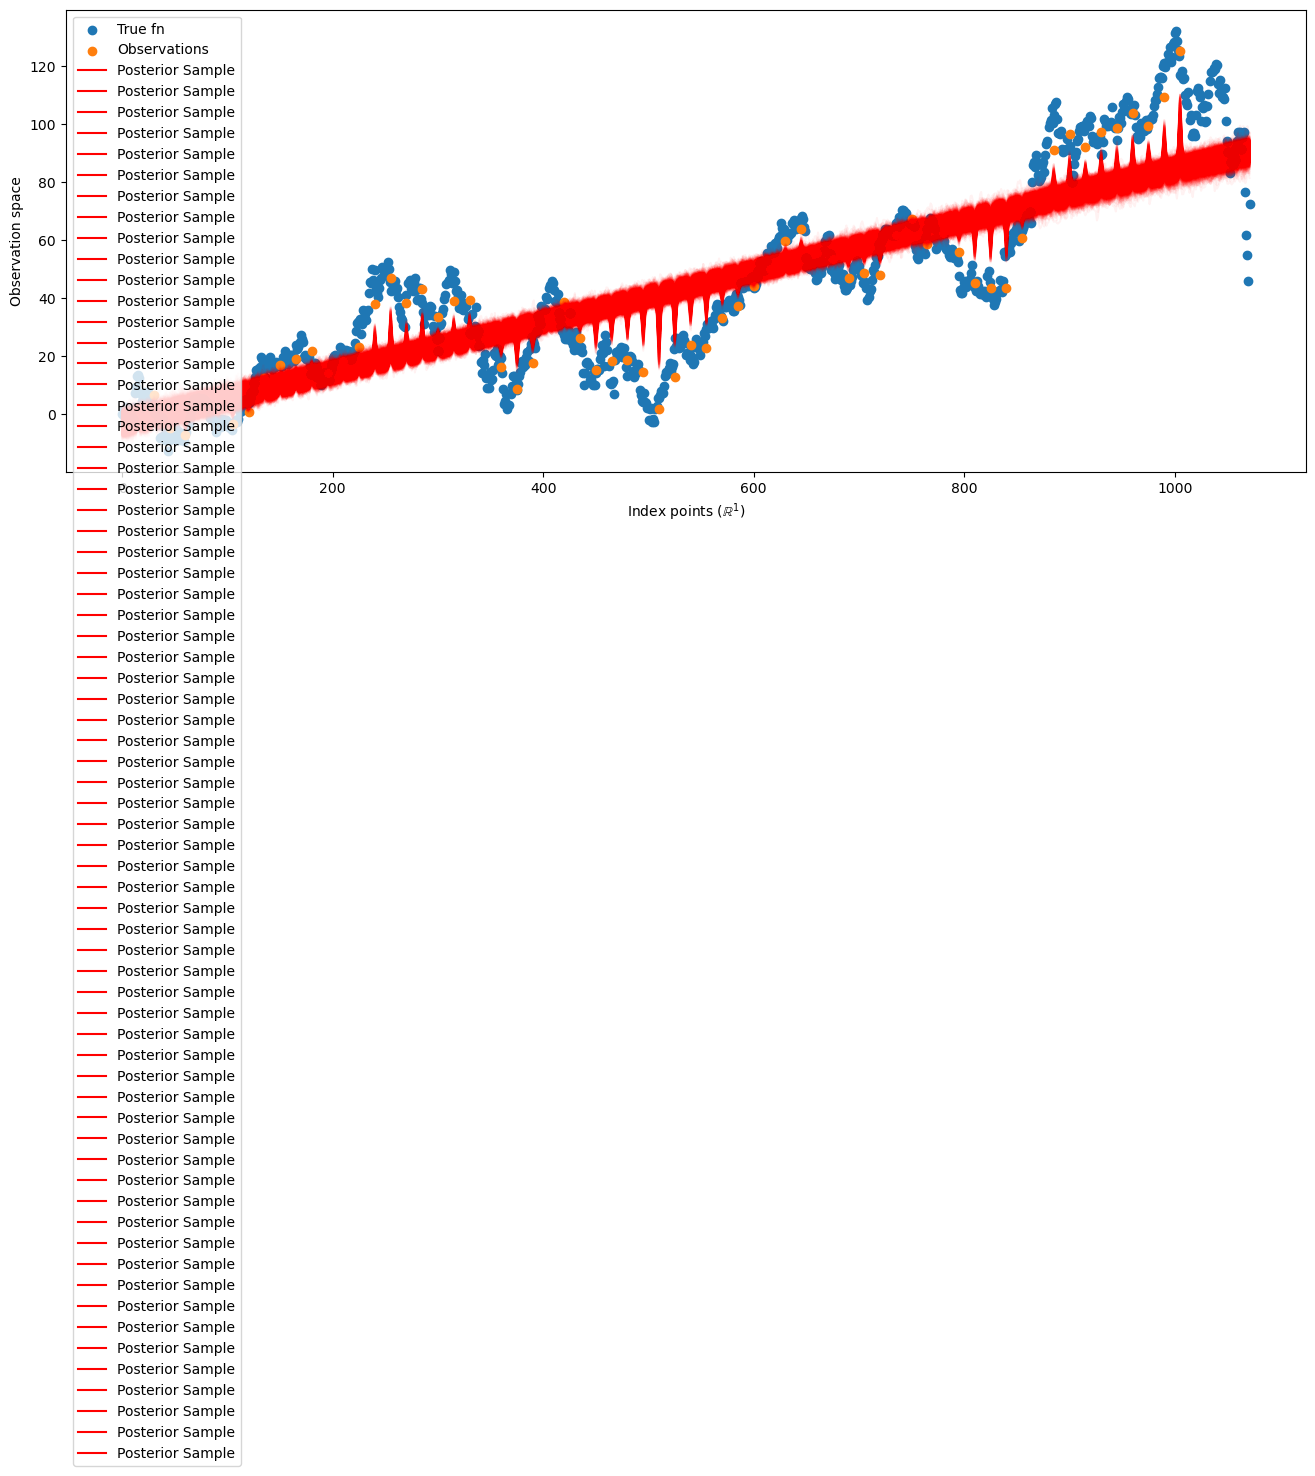

In [32]:
# Plot the true function, observations, and posterior samples.
tf.experimental.numpy.experimental_enable_numpy_behavior()
plt.figure(figsize=(16, 6))
plt.scatter(days, data,
         label='True fn')
plt.scatter(sparse_days, sparse_data,
            label='Observations')
for i in range(num_samples):
  plt.plot(days, samples[i, :].T, c='r', alpha=.05,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()